In [1]:
# Imported modules
import sys
sys.path.append("/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs")
from tools import constants

import pandas as pd 
import numpy as np 

import sys # To run the batch script

import os # To check if file exists.


import matplotlib.pyplot as plt 

In [4]:
def h2_mass_fraction_calculator(
    local_density_scale_height, 
    density, 
    metallicity, 
    clumping_factor
):

    print("I am in the function h2_mass_fraction_calculator") 


    """This function is used to calculate the H2 mass fraction by using the formula 1 in the paper:
    A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)

    Arguments:
    ----------
    local_density_scale_height: array_like
        In this equation smooting length of the gas is assumed to be accurate estimation of the local density scale height. 
        Therefore smooting length is used instead of local density scale height
        [kpc]

    density: array_like
        Density of the gas particles
        [gr / cm^3]

    metallicity: array_like
        metallicity of the gas particles 
        [Zsolar]

    clumping_factor: double or int
        It is a parameter to boost the h2 mass fraction and therefore h2 column density and CO luminosity
        [unitless]

    Returns:
    ----------
    h2_mass_fraction: array_like
        h2_mass_fraction = h2_gas_mass / total_gas_mass
        [unitless]

    column_density: array_like
        It is the column density considering all elements in the gas particle
        [gr/cm^2]

    dust_optical_depth: array_like  
        tau_c in the reference paper. It was being output in order to control the code
        [unitless]

    References: 
    -----------
    A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)

    """ 


    # The units of local_density_scale_height is kpc 
    local_density_scale_height = local_density_scale_height * constants.kpc2cm  # [cm]

    # Calculation of column density 
    column_density = density * local_density_scale_height   # [gr / cm^2]
    # Column density is the summation sign in the paper
    # Gunjan assumed that local density scale height is same with the smoooting length of the gas particles. I will continue on this assumption
    # but I don't know how it works

    # Calculation of dust cross section (sigma_d in txhe paper)
    dust_cross_section_per_H_nucleus_normalized_to_1eminus21 = metallicity
    dust_cross_section = dust_cross_section_per_H_nucleus_normalized_to_1eminus21 * 1e-21   # [cm^2]


    # Calculation of dust optical depth (tau_c in the paper)
    # mu_h is the mean mass per H nucleus
    mu_h = 2.3e-24  # [gr] 
    # clumping factor is used to increase the H2 formation to account for density inhomogeneities that are unresolved on the computational grid
    # since the H2 formation rate varies as the square of density, these inhomogeneities increase the overall rate
    dust_optical_depth = column_density * dust_cross_section / mu_h     # [dimensionless]   

    # Calculation for scaled radiation field (chi in the paper) Eq 4 
    # This scaled radiation field will not likely to hold cell-by-cell every time step, but it should hold on average
    # clumping factor is used to boost the formation rate of the H2 molecules on dust grains (the R term)   
    scaled_radiation_field = 3.1 * (1 + 3.1 * metallicity**0.365) / (4.1 * clumping_factor)  # [dimensionless]

    # Calculation for s in the paper (Eq 2)
    s = np.log(1 + 0.6*scaled_radiation_field + 0.01 * np.power(scaled_radiation_field,2)) / ( 0.6 * dust_optical_depth )

    # Calculation for the H2 mass fraction (f_H2 in the paper Eq 1)
    h2_mass_fraction = 1 - (3/4) * (s / (1 + 0.25*s))   # [dimensionless]
    h2_mass_fraction[h2_mass_fraction < 0] = 0      # If the result is negative set it to zero
    
    # Set inf values to NaN
    # Replace inf/-inf with NaN
    h2_mass_fraction[np.isinf(h2_mass_fraction)] = np.nan
    column_density[np.isinf(column_density)] = np.nan    
    dust_optical_depth[np.isinf(dust_optical_depth)] = np.nan    
    scaled_radiation_field[np.isinf(scaled_radiation_field)] = np.nan    
    dust_optical_depth[np.isinf(dust_optical_depth)] = np.nan    
    
    return h2_mass_fraction, column_density, dust_optical_depth, scaled_radiation_field, s, dust_optical_depth


In [5]:
galaxy_name = "gal20"
galaxy_type = "firebox"
redshift = "3.0"

# Read cloudy_gas_txt 
run_dir = "voronoi_1e6"
cloudy_gas_particles_file_directory = f"/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/{galaxy_type}/z{redshift}/{galaxy_name}/{run_dir}" 

cloudy_gas_particles_file_directory

'/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/firebox/z3.0/gal20/voronoi_1e6'

In [6]:
# Define the column names based on your description
gas_column_names = [
    "x", 
    "y", 
    "z", 
    "smoothing_length", 
    "mass", 
    "metallicity", # Zsolar but will be converted to mass fraction in the future
    "temperature", 
    "vx", 
    "vy", 
    "vz", 
    "hden", 
    "radius", 
    "sfr", 
    "turbulence", 
    "density", 
    "mu_theoretical", 
    "average_sobolev_smoothingLength",
    "index", 
    "isrf"
]


gas_particles_df = pd.read_csv(
    f"{cloudy_gas_particles_file_directory}/cloudy_gas_particles.txt",
    delim_whitespace=True, 
    comment='#', 
    names=gas_column_names
)


In [7]:
total_sfr = sum(gas_particles_df['sfr'])
print(f"Total sfr: {total_sfr} Msolar / year")

Total sfr: 34.99827562549998 Msolar / year


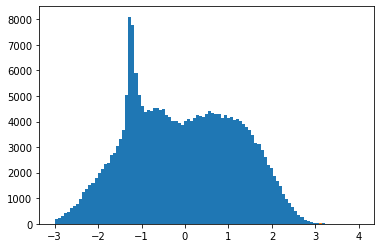

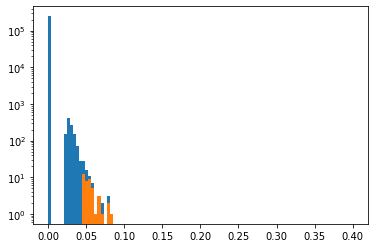

In [10]:
hden_condition = gas_particles_df['density'] / (constants.proton_mass * constants.kg2g * constants.mu_h) >= 1e3


bins = np.linspace(start=-3, stop=4, num=100)
plt.hist(np.log10(gas_particles_df['hden']), bins=bins)
plt.hist(np.log10(gas_particles_df[hden_condition]['hden']), bins=bins)
plt.show()


bins = np.linspace(start=0, stop=0.4, num=100)
plt.hist(gas_particles_df['sfr'], bins=bins)
plt.hist(gas_particles_df[hden_condition]['sfr'], bins=bins)
plt.yscale("log")
plt.show()

